# Predicting Passenger Satisfaction

## Framing the Problem
### Business Objective 
We want to build a model that predicts passenger satisfaction to analyze what factors affect the flying experience. From uncovering those factors for different customer groups, we can optimize on them to create a better passenger experience and in turn improve retention of product, increase customer loyalty and drive up revenue.

### The Model
We will be using 2 types of models: Logistic Regression and Support Vector Machines. Both of these models are easy to implement and interpretable.

Since logistic regression assumes a linear relationship between the explanatory and response variables while SVM can assume a non-linear relationship, we can compare these 2 models to see which one fits the data better. 

### Performance Assessment 
We will be using the F1-score and the precision-recall (PR) curve to assess and compare our models. 

We want to minimize the number of passengers that we misclassify as being satisfied (when they're actually dissatisfied) so that we can pinpoint what are areas of dissatisfaction). However, we also want to minimize the number of passengers we misclassify as not being satisfied (when they're actually satisfied) so that we can find factors that are contributing to a satisfied passenger. 

A precision-recall curve is to support our F1 score and also because we should care more about misclassifying a disatissfied passenger, from a customer experience perspective. 

### Assumptions
We're assuming that each entry of the dataset are independent from each other and that one passenger's satisfaction doesn't affect another passenger's. We're also assuming that each entry of the data is coming from the same distribution. 

## Exploratory Data Analysis

In [1]:
# pyspark for EDA imports
import pyspark
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.ml.stat import Correlation
from pyspark.ml import feature as ft
import pyspark.ml as ml
from pyspark.sql.functions import *
from pyspark.sql.types import *


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# start spark session
spark = SparkSession.builder.appName('pax_satisfaction').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/27 18:42:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# importing the data
pax_sat_df = spark.read.options(header = True, emptyValue = NullType).csv("/Users/huongngo/Desktop/PERSONAL PROJECTS/customer_satisfaction/data/satisfaction.csv")
# data type
print(f"dataframe type: {type(pax_sat_df)}")

dataframe type: <class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
# datatype overview
print("Columns Overview")
pd.DataFrame(pax_sat_df.dtypes, columns = ['Column', 'Data Type'])

Columns Overview


,Column,Data Type
0,id,string
1,satisfaction_v2,string
2,Gender,string
3,Customer Type,string
4,Age,string
5,Type of Travel,string
6,Class,string
7,Flight Distance,string
8,Seat comfort,string
9,Departure/Arrival time convenient,string


In [5]:
# first 5 rows of half of dataset
pax_sat_df.select(pax_sat_df.columns[:13]).limit(5).toPandas()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4


In [6]:
# first 5 rows of other half of dataset
pax_sat_df.select(pax_sat_df.columns[13:]).limit(5).toPandas()

,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,4,2,3,3,0,3,5,3,2,0,0
1,2,2,3,4,4,4,2,3,2,310,305
2,0,2,2,3,3,4,4,4,2,0,0
3,4,3,1,1,0,1,4,1,3,0,0
4,3,4,2,2,0,2,4,2,5,0,0


In [7]:
# assigning columns that are numerical and string
numeric_columns = pax_sat_df.columns[7:] + ['id', 'Age']
string_columns = pax_sat_df.columns[1:4] + pax_sat_df.columns[5:7]

In [8]:
# re-casting correct data type to columns that are supposed to be numeric
for column in numeric_columns:
    pax_sat_df = pax_sat_df.withColumn(column, col(column).cast(IntegerType()))

In [9]:
# reprinting out the datatype
print("Columns Overview")
col_overview = pd.DataFrame(pax_sat_df.dtypes, columns = ['Column', 'Data Type'])
col_overview

Columns Overview


,Column,Data Type
0,id,int
1,satisfaction_v2,string
2,Gender,string
3,Customer Type,string
4,Age,int
5,Type of Travel,string
6,Class,string
7,Flight Distance,int
8,Seat comfort,int
9,Departure/Arrival time convenient,int


In [10]:
# printing out more specific datatype
col_overview['Specific Data Type'] = ['NO', 'NO', 'NO', 'OR', 'NU', 'NO', 'OR', 'NU'] + ['OR'] * 14 + ['NU', 'NU']
col_overview

,Column,Data Type,Specific Data Type
0,id,int,NO
1,satisfaction_v2,string,NO
2,Gender,string,NO
3,Customer Type,string,OR
4,Age,int,NU
5,Type of Travel,string,NO
6,Class,string,OR
7,Flight Distance,int,NU
8,Seat comfort,int,OR
9,Departure/Arrival time convenient,int,OR


In [11]:
# printing out number of unique values in dataset
temp_df = pax_sat_df.select([count_distinct(column).alias(column) for column in pax_sat_df.columns])
temp_df.toPandas().T

22/11/27 18:42:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0
id,129880
satisfaction_v2,2
Gender,2
Customer Type,2
Age,75
Type of Travel,2
Class,3
Flight Distance,5398
Seat comfort,6
Departure/Arrival time convenient,6


In [12]:
# getting summary statistics on numeric columns
pax_sat_df.describe(numeric_columns).toPandas()

,summary,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,id,Age
0,count,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129487,129880,129880
1,mean,1981.409054511857,2.838597166615337,2.990645210963967,2.851994148444718,2.990421927933477,3.2491299661225748,3.3834770557437635,3.519702802587003,3.4721050200184784,3.465075454265476,3.485902371419772,3.695672928857407,3.3408068986757007,3.7057591623036648,3.3525870033877427,14.713712657838004,15.09112883918849,64940.5,39.42795657530028
2,stddev,1027.115605613396,1.3929832432699039,1.5272243703451152,1.44372938657304,1.3059698939850506,1.3188175196680614,1.3460591444981043,1.306510690351753,1.3055596480285887,1.2708355823355082,1.292225983002256,1.1564833967397006,1.26058228495459,1.1517739117986903,1.2987145021407407,38.0711262150364,38.46565024011914,37493.27081846375,15.119359950371685
3,min,50,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7
4,max,6951,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1592,1584,129880,85


In [13]:
# printing out amount of "missing" values for numeric columns
# when entry = 0, it is "missing" (not applicable)
amount_missing_df = pax_sat_df.select([(count(when(pax_sat_df[column] == 0, column))/count(lit(1))) \
.alias(column) for column in numeric_columns])
amount_missing_df.toPandas()

,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,id,Age
0,0.0,0.036934,0.051309,0.045773,0.000015,0.001016,0.022929,0.000008,0.000139,0.000038,0.003419,0.0,0.000008,0.000038,0.000108,0.564798,0.560156,0.0,0.0


In [14]:
# amount of missing data for string columns
amount_missing_df = pax_sat_df.select([(count(when(isnull(column) | isnan(column), column))/count(lit(1))) \
.alias(column) for column in string_columns])
amount_missing_df.toPandas()

,satisfaction_v2,Gender,Customer Type,Type of Travel,Class
0,0.0,0.0,0.0,0.0,0.0


In [15]:
# converting dataset to pandas for plotting
pdf = pax_sat_df.toPandas()
pdf.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,...,4,2,2,0,2,4,2,5,0,0.0


/Users/huongngo/opt/anaconda3/envs/pax_satisfaction/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

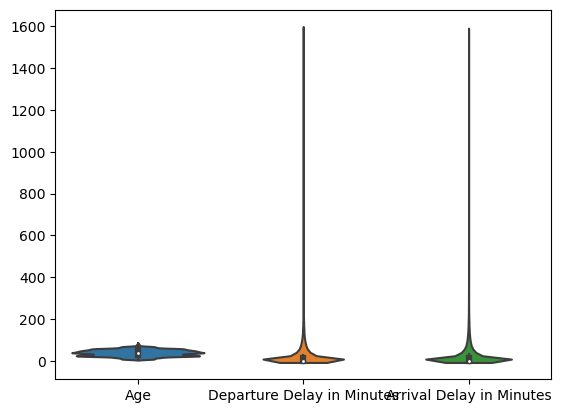

In [16]:
sns.violinplot(data = pdf[['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']])

<AxesSubplot:>

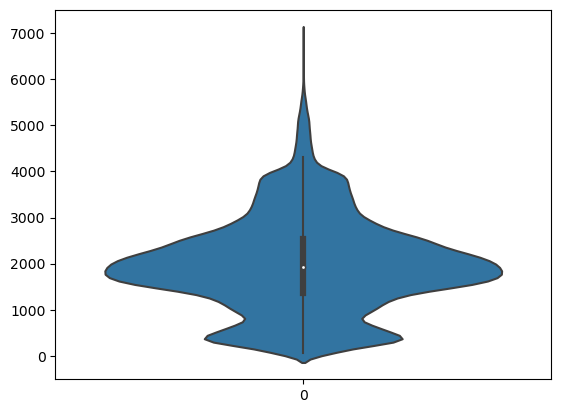

In [17]:
sns.violinplot(data = pdf['Flight Distance'])

In [18]:
# getting the frequency tables of each feature
seat_comfort_cnt = pd.DataFrame(pdf.groupby('Seat comfort').count()['id'])
cus_type_cnt = pd.DataFrame(pdf.groupby('Customer Type').count()['id'])
food_drink_cnt = pd.DataFrame(pdf.groupby('Food and drink').count()['id'])
gate_loc_cnt = pd.DataFrame(pdf.groupby('Gate location').count()['id'])

class_cnt = pd.DataFrame(pdf.groupby('Class').count()['id'])
conven_cnt = pd.DataFrame(pdf.groupby('Departure/Arrival time convenient').count()['id'])
wifi_cnt = pd.DataFrame(pdf.groupby('Inflight wifi service').count()['id'])
ent_cnt = pd.DataFrame(pdf.groupby('Inflight entertainment').count()['id'])

support_cnt = pd.DataFrame(pdf.groupby('Online support').count()['id'])
booking_cnt = pd.DataFrame(pdf.groupby('Ease of Online booking').count()['id'])
on_board_cnt = pd.DataFrame(pdf.groupby('On-board service').count()['id'])
leg_room_cnt = pd.DataFrame(pdf.groupby('Leg room service').count()['id'])

baggage_cnt = pd.DataFrame(pdf.groupby('Baggage handling').count()['id'])
checkin_cnt = pd.DataFrame(pdf.groupby('Checkin service').count()['id'])
clean_cnt = pd.DataFrame(pdf.groupby('Cleanliness').count()['id'])
boarding_cnt = pd.DataFrame(pdf.groupby('Online boarding').count()['id'])

<AxesSubplot:xlabel='Gate location', ylabel='id'>

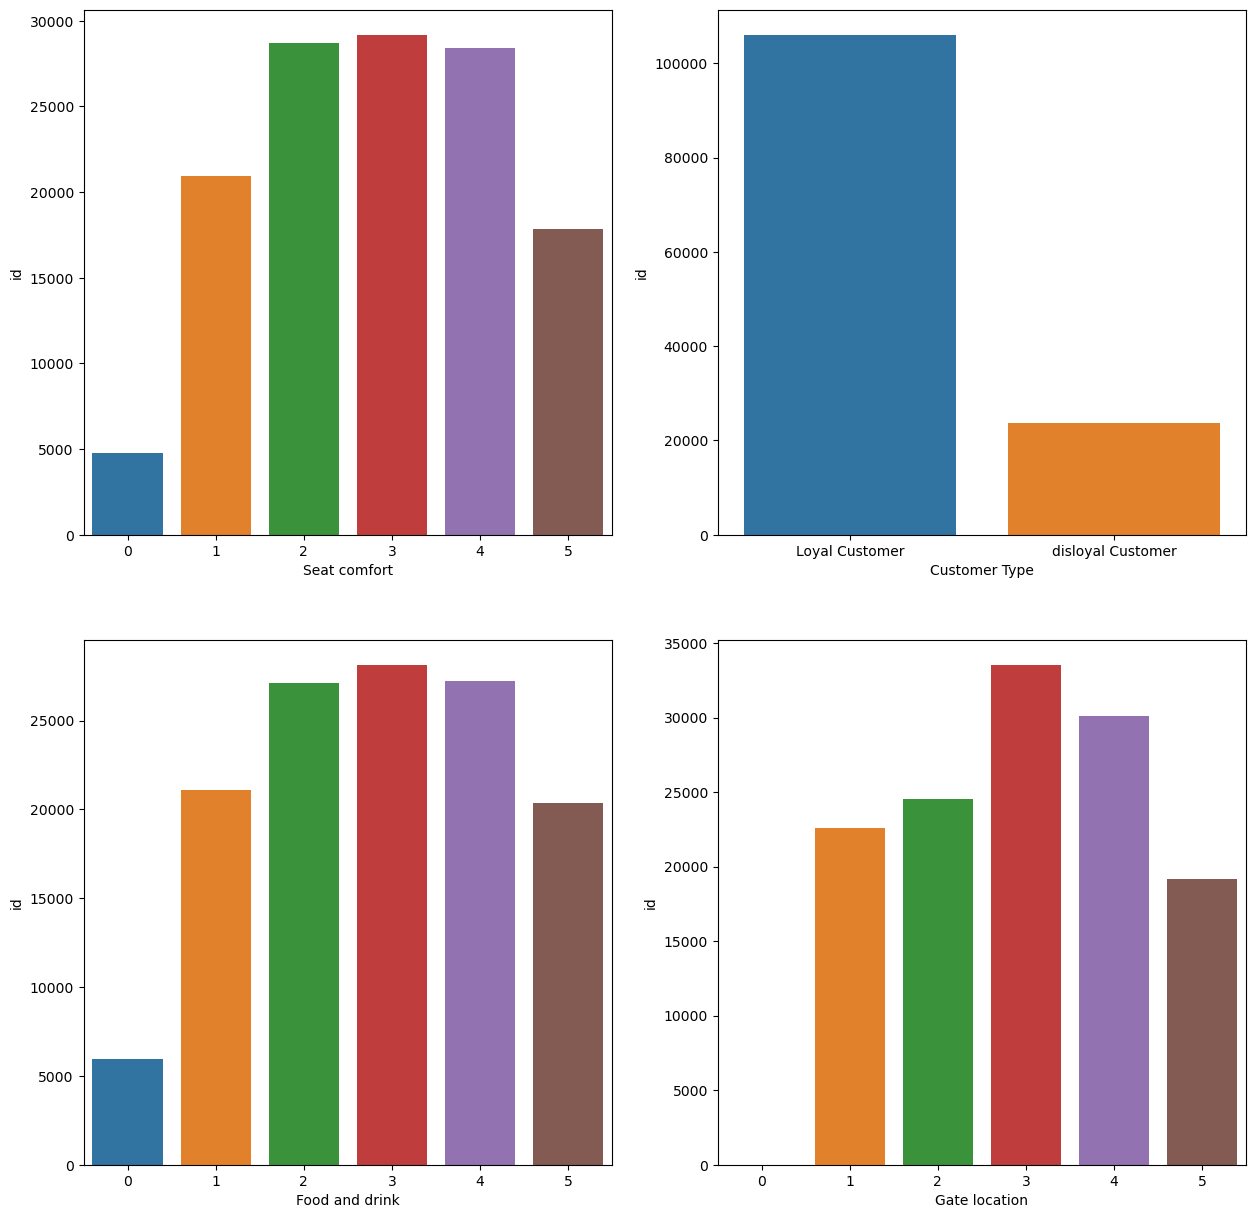

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = seat_comfort_cnt, x = seat_comfort_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = cus_type_cnt, x = cus_type_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = food_drink_cnt, x = food_drink_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = gate_loc_cnt, x = gate_loc_cnt.index, y = 'id')

<AxesSubplot:xlabel='Inflight entertainment', ylabel='id'>

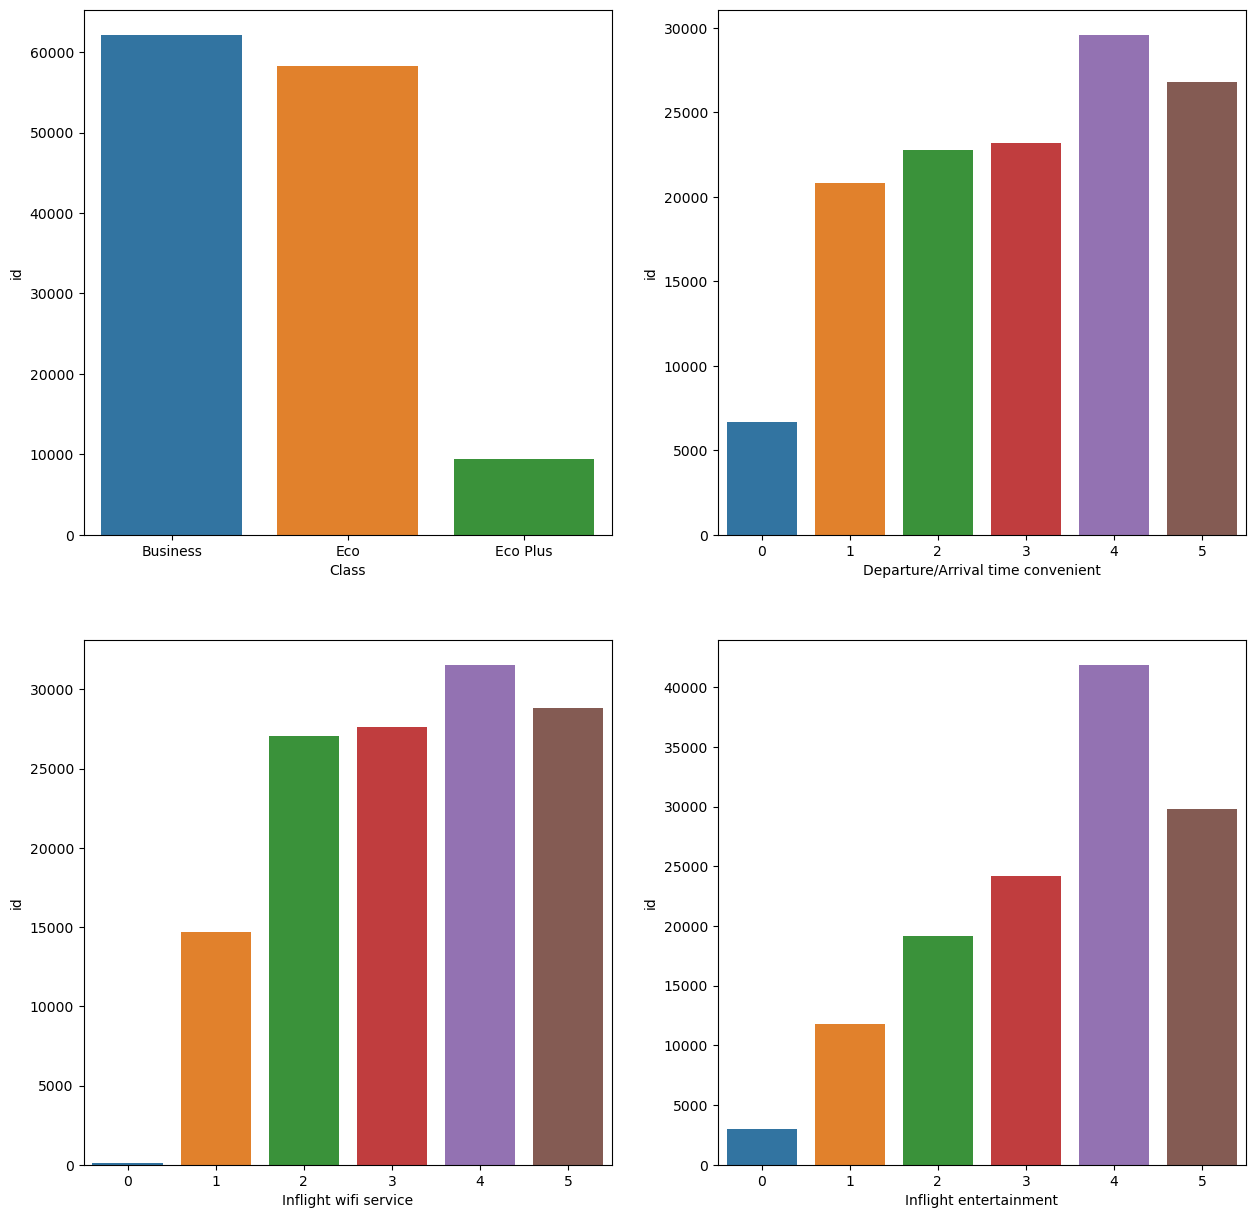

In [20]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = class_cnt, x = class_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = conven_cnt, x = conven_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = wifi_cnt, x = wifi_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = ent_cnt, x = ent_cnt.index, y = 'id')

<AxesSubplot:xlabel='Leg room service', ylabel='id'>

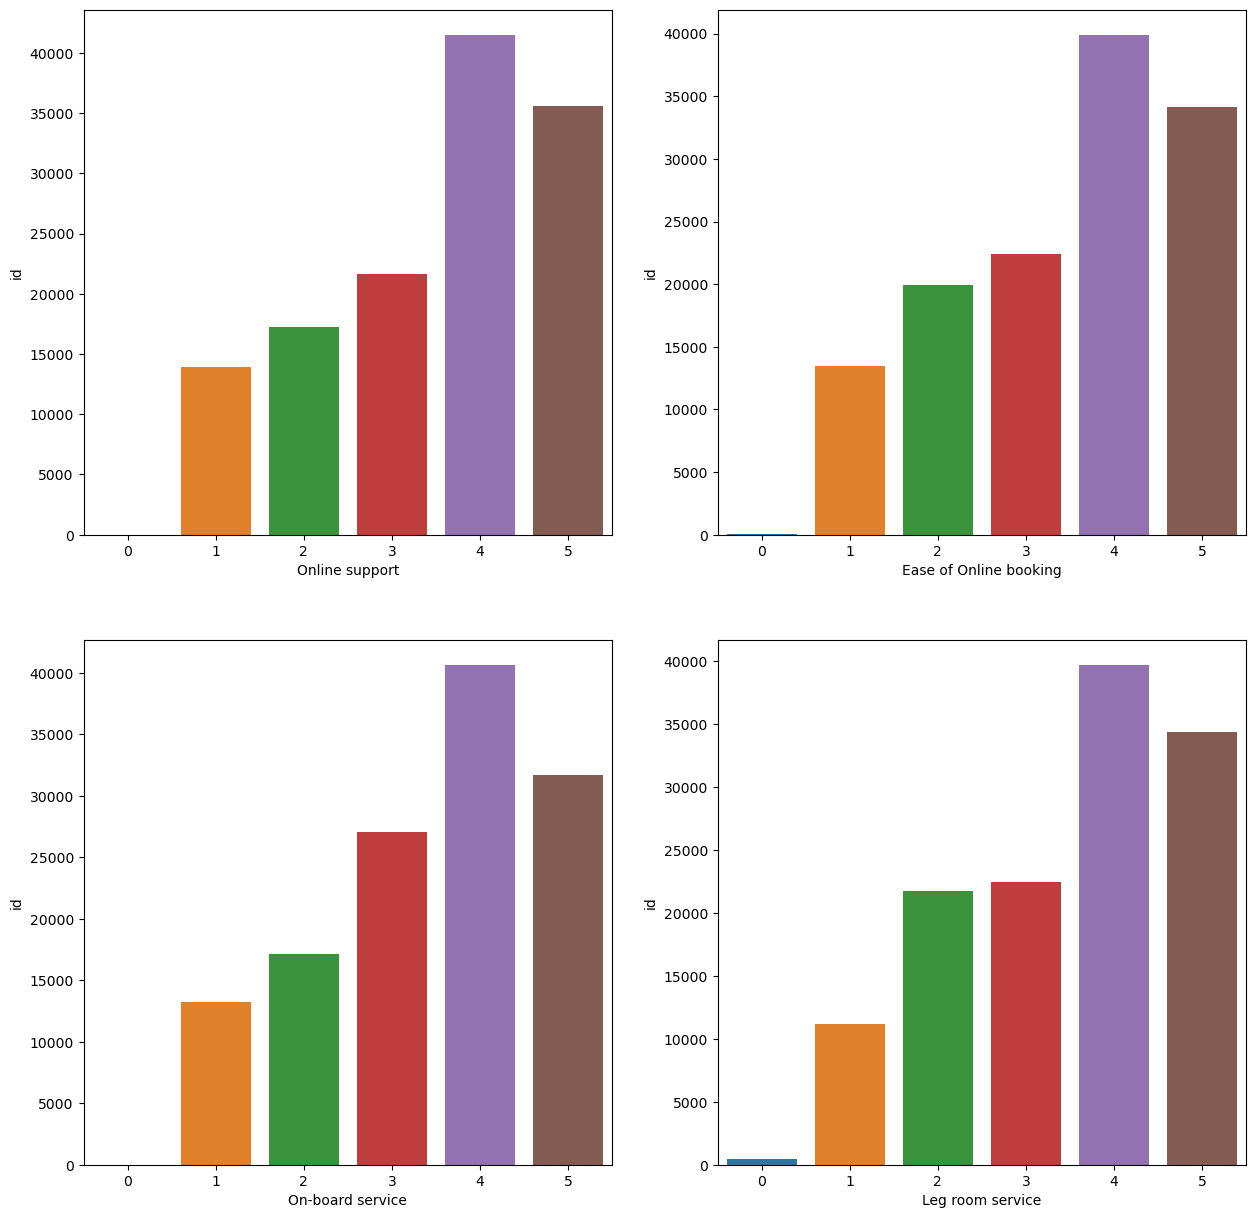

In [21]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = support_cnt, x = support_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = booking_cnt, x = booking_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = on_board_cnt, x = on_board_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = leg_room_cnt, x = leg_room_cnt.index, y = 'id')

<AxesSubplot:xlabel='Online boarding', ylabel='id'>

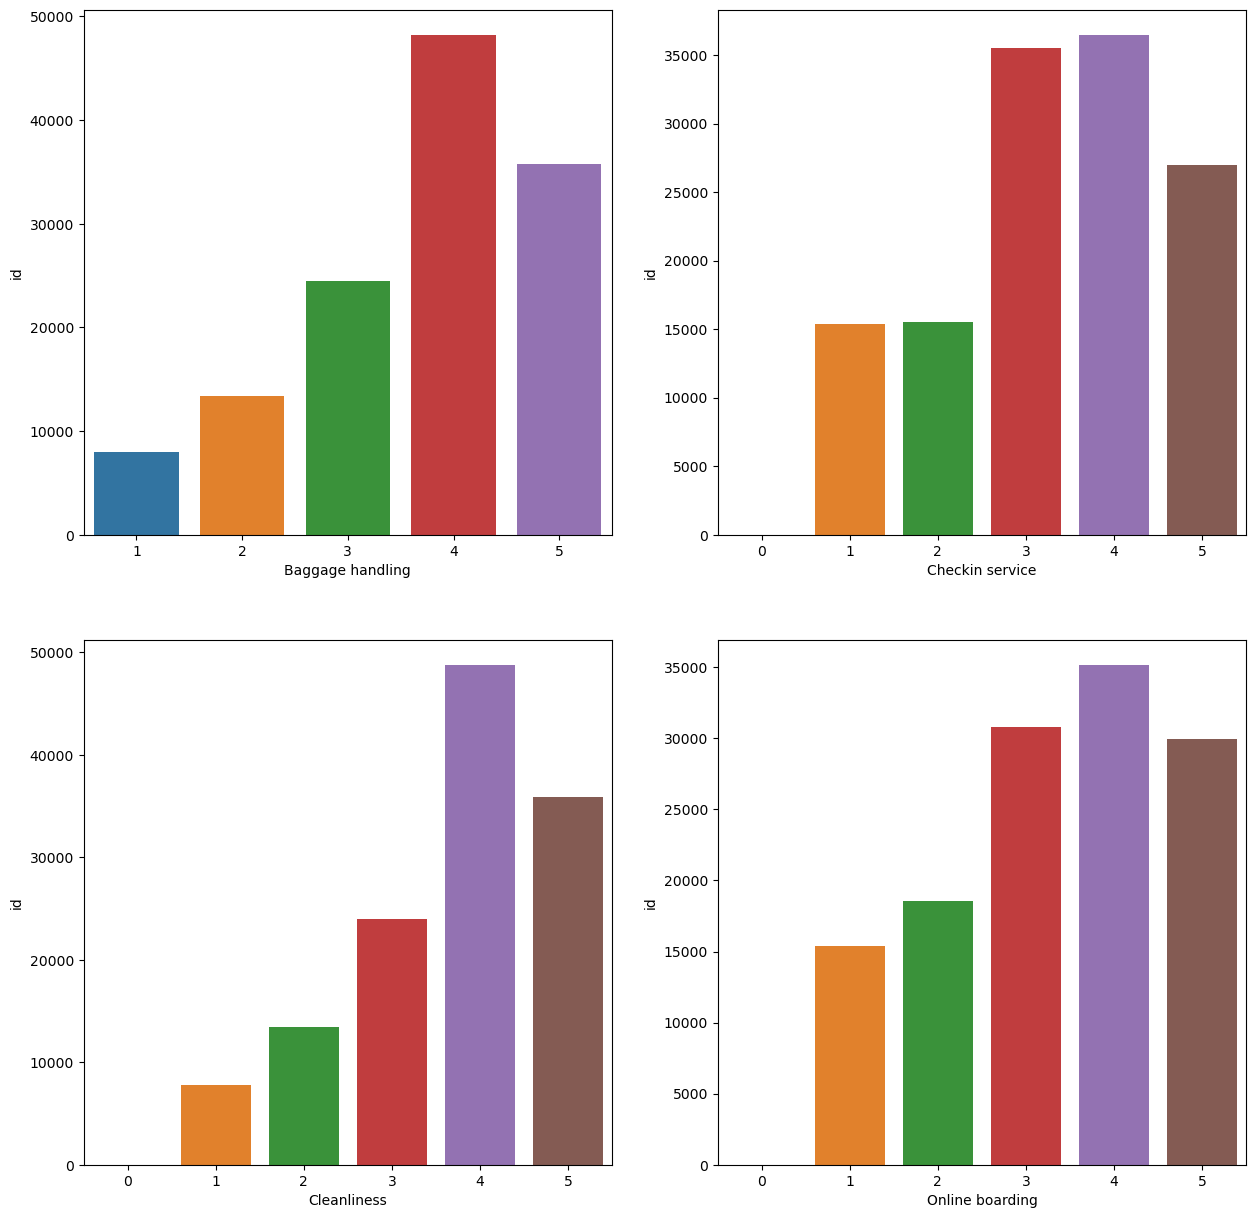

In [22]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = baggage_cnt, x = baggage_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = checkin_cnt, x = checkin_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = clean_cnt, x = clean_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = boarding_cnt, x = boarding_cnt.index, y = 'id')

In [23]:
delays_df = pax_sat_df.select('id', 'Departure Delay in Minutes', 'Arrival Delay in Minutes')

In [24]:
# replacing 0 with None 
temp_df = pax_sat_df.drop('Departure Delay in Minutes', 'Arrival Delay in Minutes')
num_cols = temp_df.columns[7:]
temp_df = temp_df.replace(0, None)
# getting the amount missing for numeric columns
amount_missing_df = temp_df.select([(count(when(isnull(column), column))/count(lit(1))) \
.alias(column) for column in num_cols])
amount_missing_df.toPandas()

,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding
0,0.0,0.036934,0.051309,0.045773,0.000015,0.001016,0.022929,0.000008,0.000139,0.000038,0.003419,0.0,0.000008,0.000038,0.000108


In [25]:
# imports for imputation of missing values
from pyspark.ml.feature import Imputer

In [26]:
# setting imputation strategy
imputer = Imputer(strategy = 'median')
# setting input columns for imputation
imputer.setInputCols(num_cols[1:])
# setting output columns for imputation
imputer.setOutputCols([f'out_{column}' for column in (num_cols[1:])])

Imputer_fd4408db7768

In [27]:
# get relative error of imputer
imputer.getRelativeError()

0.001

In [28]:
# fit imputer to dataset
model = imputer.fit(pax_sat_df)
# setting input columns for model from dataset (only columns that have "missing"/not applicable values)
model.setInputCols(num_cols[1:])

ImputerModel: uid=Imputer_fd4408db7768, strategy=median, missingValue=NaN, numInputCols=14, numOutputCols=14

In [29]:
# transforming dataset with imputer (apply imputer and outputting values)
pax_sat_df_impute = model.transform(temp_df)
# view first 5 rows of all columns after imputation
pax_sat_df_impute.select('*').limit(5).toPandas()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,out_Inflight wifi service,out_Inflight entertainment,out_Online support,out_Ease of Online booking,out_On-board service,out_Leg room service,out_Baggage handling,out_Checkin service,out_Cleanliness,out_Online boarding
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,NaN,NaN,...,2,4,2,3,3,4,3,5,3,2
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,NaN,NaN,...,3,2,2,3,4,4,4,2,3,2
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,NaN,NaN,...,2,4,2,2,3,3,4,4,4,2
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,NaN,NaN,...,3,4,3,1,1,4,1,4,1,3
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,NaN,NaN,...,4,3,4,2,2,4,2,4,2,5


In [30]:
# dropping old non-imputed columns
for column in num_cols[1:]:
    pax_sat_df_impute = pax_sat_df_impute.drop(column)

In [31]:
# checking if the all the old columns are dropped
print(pax_sat_df_impute.columns)

['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'out_Seat comfort', 'out_Departure/Arrival time convenient', 'out_Food and drink', 'out_Gate location', 'out_Inflight wifi service', 'out_Inflight entertainment', 'out_Online support', 'out_Ease of Online booking', 'out_On-board service', 'out_Leg room service', 'out_Baggage handling', 'out_Checkin service', 'out_Cleanliness', 'out_Online boarding']


In [32]:
# renaming the output columns from imputation
for i, column in enumerate(pax_sat_df_impute.columns[8:]):
    pax_sat_df_impute = pax_sat_df_impute.withColumnRenamed(column, column[4:])
print(pax_sat_df_impute.columns)

['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


In [33]:
delays_df.select('*').limit(5).toPandas()

,id,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,0,0
1,110278,310,305
2,103199,0,0
3,47462,0,0
4,120011,0,0


Resource: https://www.geeksforgeeks.org/how-to-avoid-duplicate-columns-after-join-in-pyspark/

In [34]:
pax_sat_df_impute = pax_sat_df_impute.join(delays_df, pax_sat_df_impute.id == delays_df.id, 'inner') \
    .drop(delays_df.id)

In [35]:
pax_sat_df_impute.select('*').limit(5).toPandas()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,3,3,...,2,3,3,4,3,5,3,2,0,0
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,3,3,...,2,3,4,4,4,2,3,2,310,305
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,3,3,...,2,2,3,3,4,4,4,2,0,0
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,3,3,...,3,1,1,4,1,4,1,3,0,0
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,3,3,...,4,2,2,4,2,4,2,5,0,0


In [36]:
# converting to pandas dataframe for plotting
pdf = pax_sat_df_impute.toPandas()

In [37]:
pdf.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,3,3,...,2,3,3,4,3,5,3,2,0,0.0
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,3,3,...,2,3,4,4,4,2,3,2,310,305.0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,3,3,...,2,2,3,3,4,4,4,2,0,0.0
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,3,3,...,3,1,1,4,1,4,1,3,0,0.0
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,3,3,...,4,2,2,4,2,4,2,5,0,0.0


In [38]:
seat_comfort_cnt = pd.DataFrame(pdf.groupby('Seat comfort').count()['id'])
cus_type_cnt = pd.DataFrame(pdf.groupby('Customer Type').count()['id'])
food_drink_cnt = pd.DataFrame(pdf.groupby('Food and drink').count()['id'])
gate_loc_cnt = pd.DataFrame(pdf.groupby('Gate location').count()['id'])

class_cnt = pd.DataFrame(pdf.groupby('Class').count()['id'])
conven_cnt = pd.DataFrame(pdf.groupby('Departure/Arrival time convenient').count()['id'])
wifi_cnt = pd.DataFrame(pdf.groupby('Inflight wifi service').count()['id'])
ent_cnt = pd.DataFrame(pdf.groupby('Inflight entertainment').count()['id'])

support_cnt = pd.DataFrame(pdf.groupby('Online support').count()['id'])
booking_cnt = pd.DataFrame(pdf.groupby('Ease of Online booking').count()['id'])
on_board_cnt = pd.DataFrame(pdf.groupby('On-board service').count()['id'])
leg_room_cnt = pd.DataFrame(pdf.groupby('Leg room service').count()['id'])

baggage_cnt = pd.DataFrame(pdf.groupby('Baggage handling').count()['id'])
checkin_cnt = pd.DataFrame(pdf.groupby('Checkin service').count()['id'])
clean_cnt = pd.DataFrame(pdf.groupby('Cleanliness').count()['id'])
boarding_cnt = pd.DataFrame(pdf.groupby('Online boarding').count()['id'])

<AxesSubplot:xlabel='Gate location', ylabel='id'>

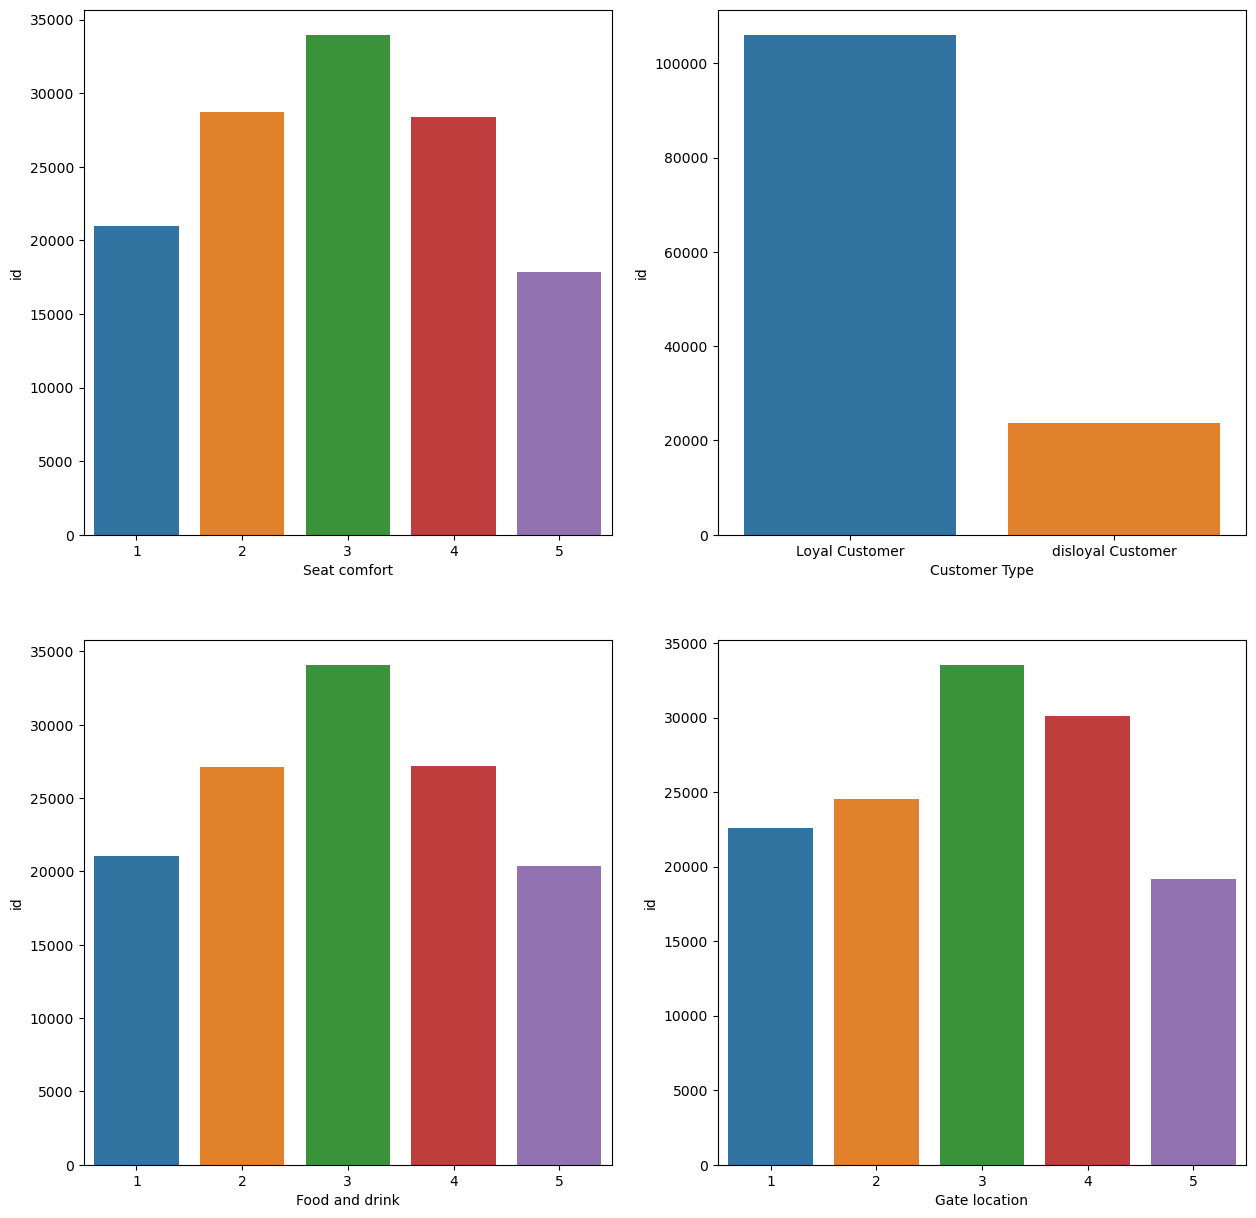

In [39]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = seat_comfort_cnt, x = seat_comfort_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = cus_type_cnt, x = cus_type_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = food_drink_cnt, x = food_drink_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = gate_loc_cnt, x = gate_loc_cnt.index, y = 'id')

<AxesSubplot:xlabel='Inflight entertainment', ylabel='id'>

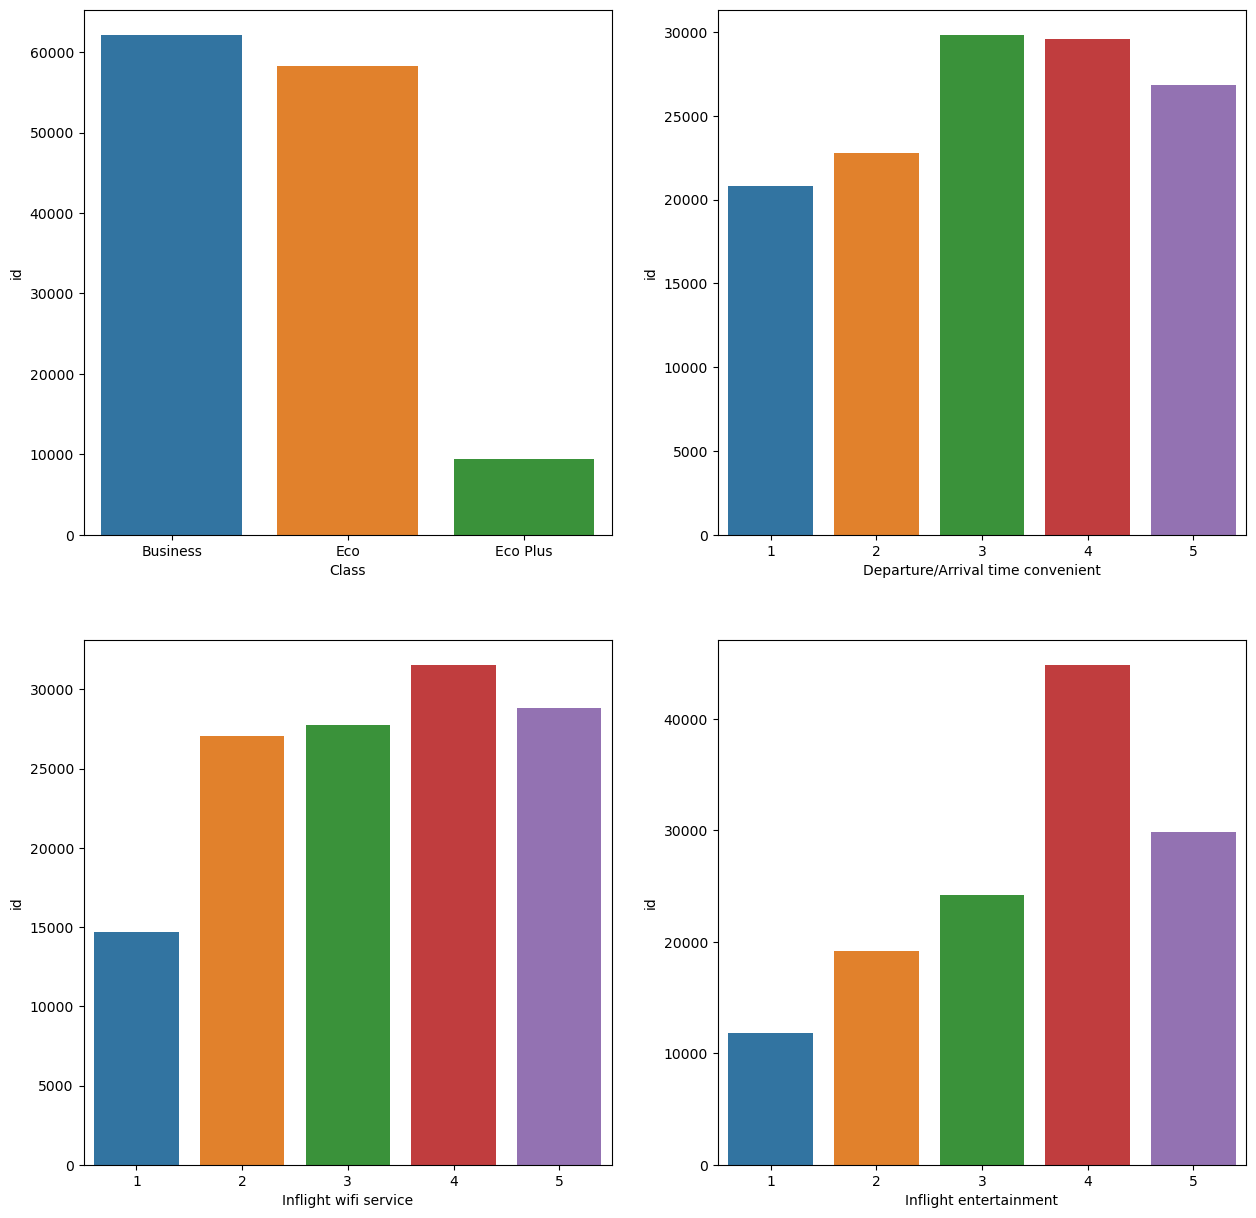

In [40]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = class_cnt, x = class_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = conven_cnt, x = conven_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = wifi_cnt, x = wifi_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = ent_cnt, x = ent_cnt.index, y = 'id')

<AxesSubplot:xlabel='Leg room service', ylabel='id'>

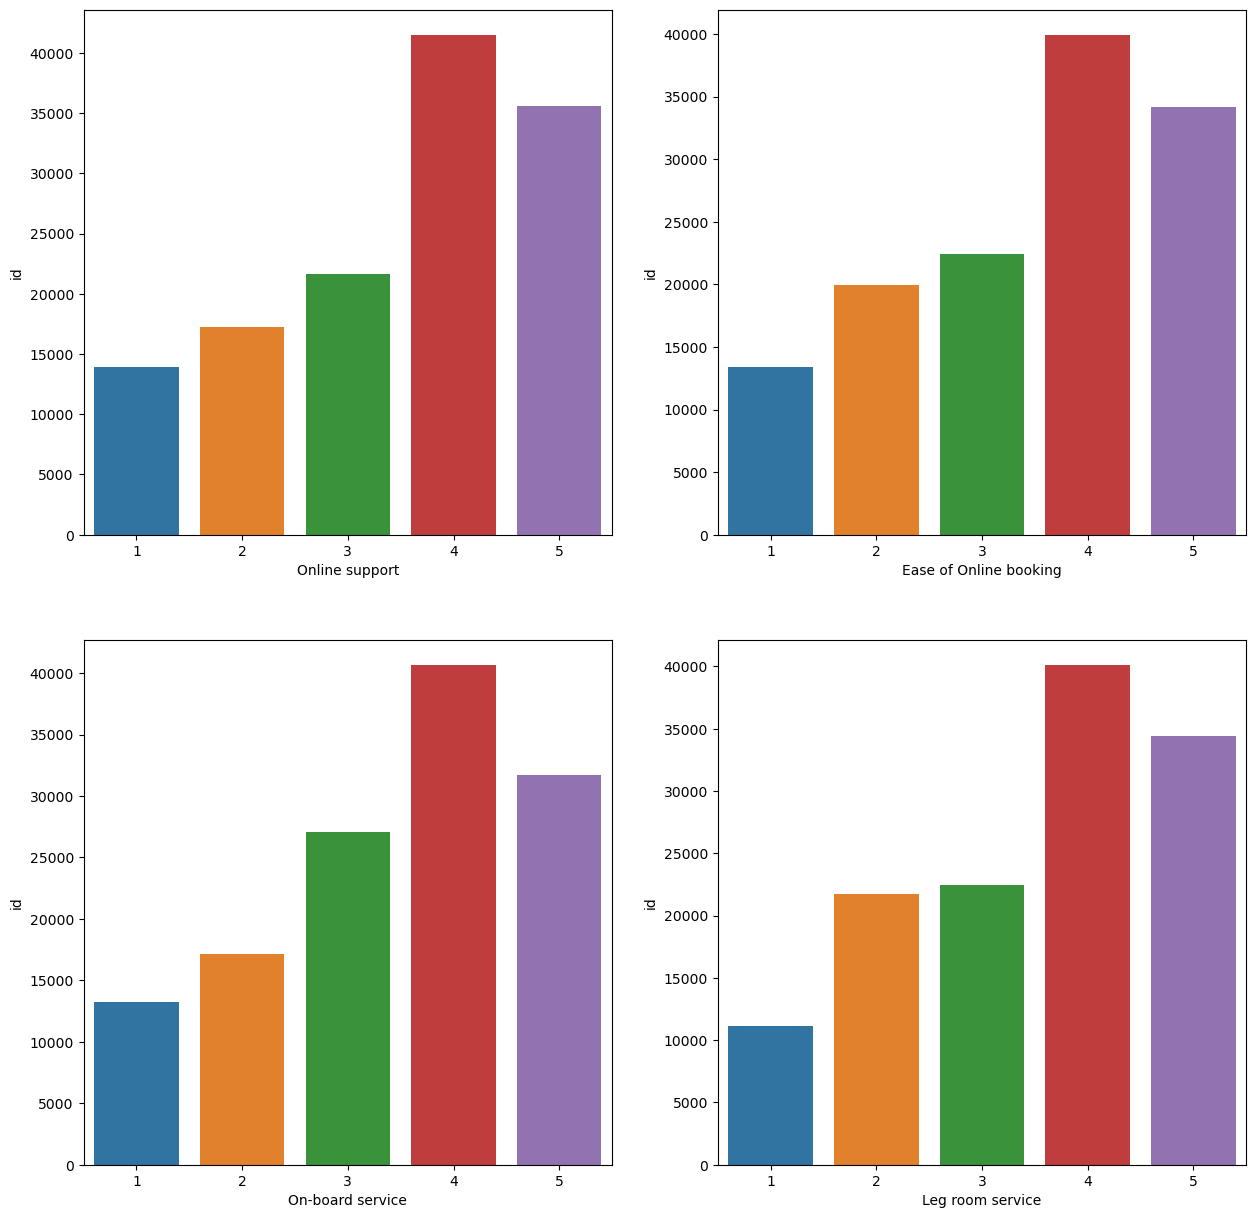

In [41]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = support_cnt, x = support_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = booking_cnt, x = booking_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = on_board_cnt, x = on_board_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = leg_room_cnt, x = leg_room_cnt.index, y = 'id')

<AxesSubplot:xlabel='Online boarding', ylabel='id'>

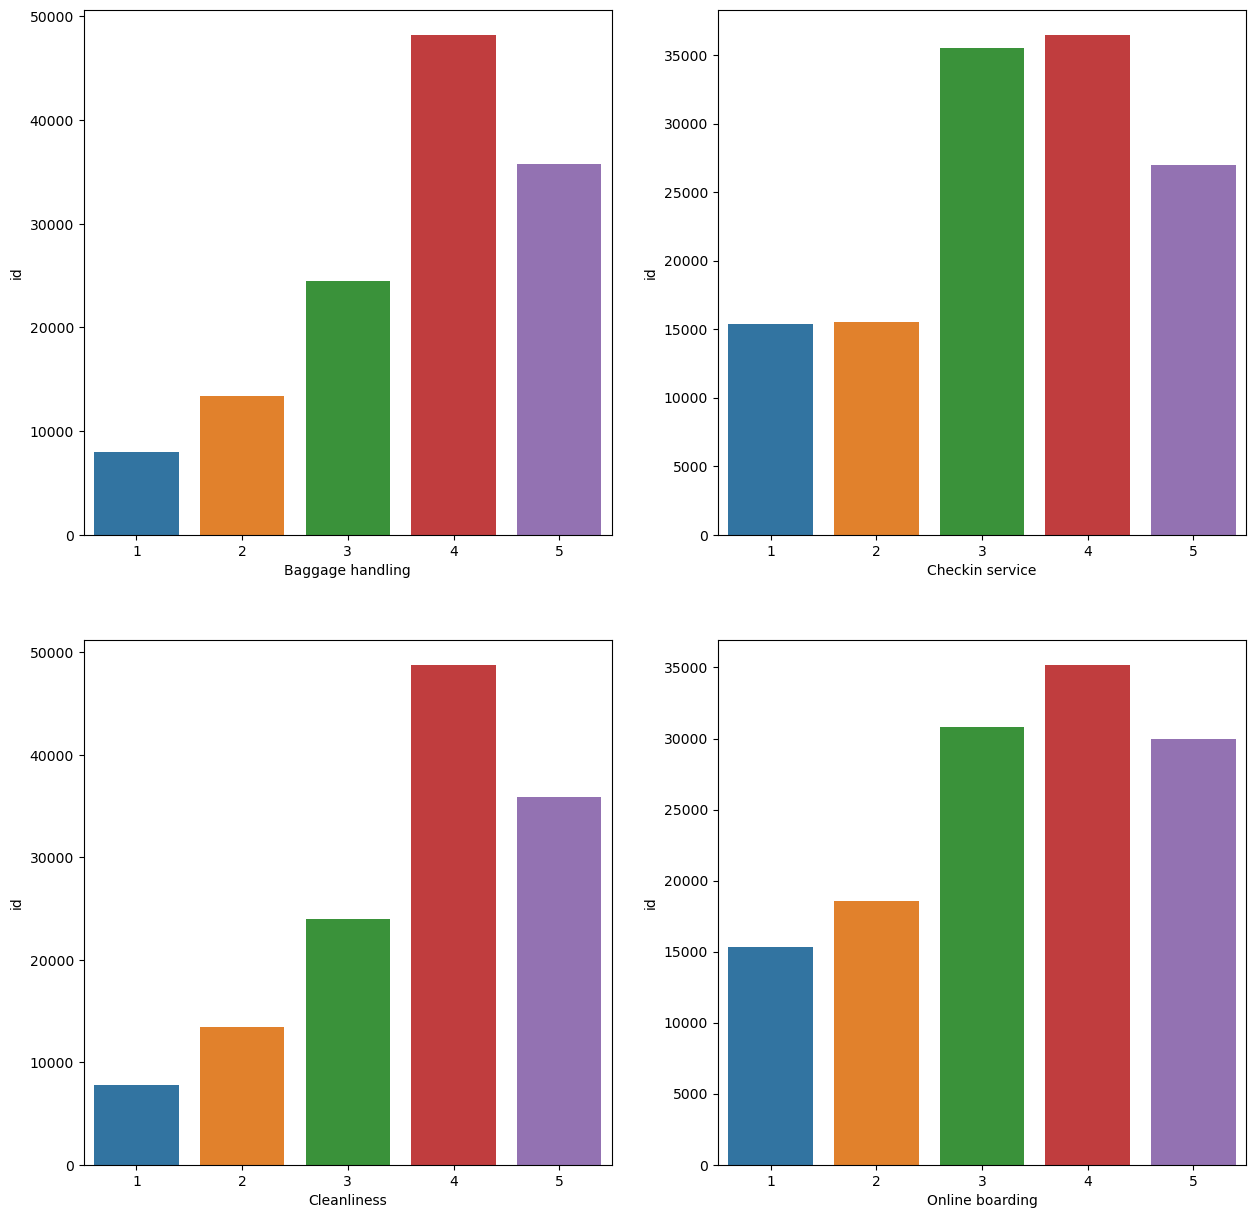

In [42]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = baggage_cnt, x = baggage_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = checkin_cnt, x = checkin_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = clean_cnt, x = clean_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = boarding_cnt, x = boarding_cnt.index, y = 'id')

<AxesSubplot:xlabel='Arrival Delay in Minutes'>

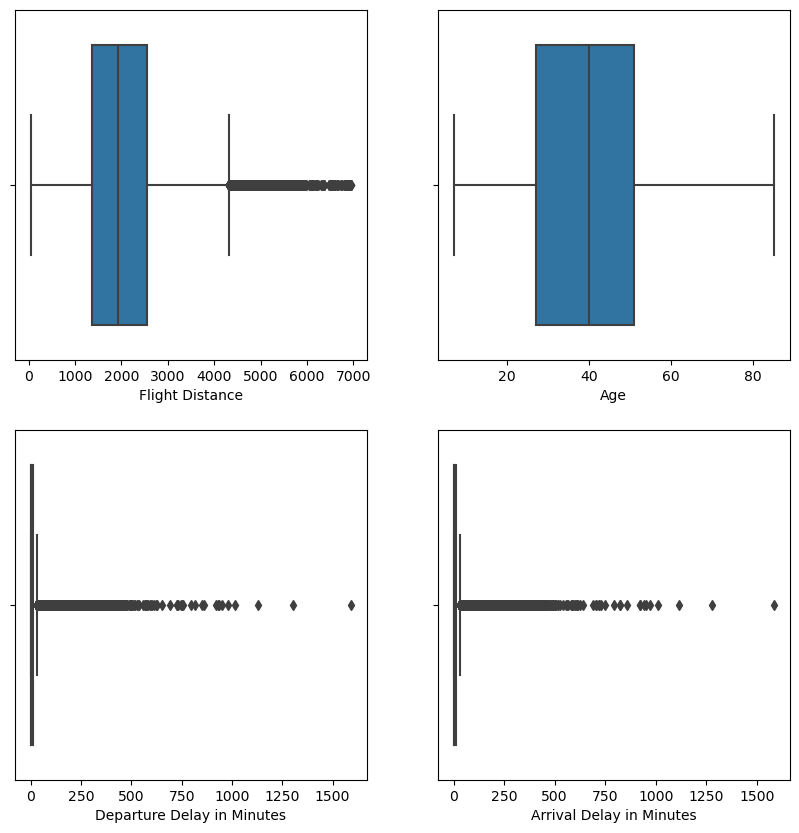

In [43]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
sns.boxplot(ax = axes[0, 0], data = pdf, x = 'Flight Distance')
sns.boxplot(ax = axes[0, 1], data = pdf, x = 'Age')
sns.boxplot(ax = axes[1, 0], data = pdf, x = 'Departure Delay in Minutes')
sns.boxplot(ax = axes[1, 1], data = pdf, x = 'Arrival Delay in Minutes')

<AxesSubplot:xlabel='satisfaction_v2', ylabel='id'>

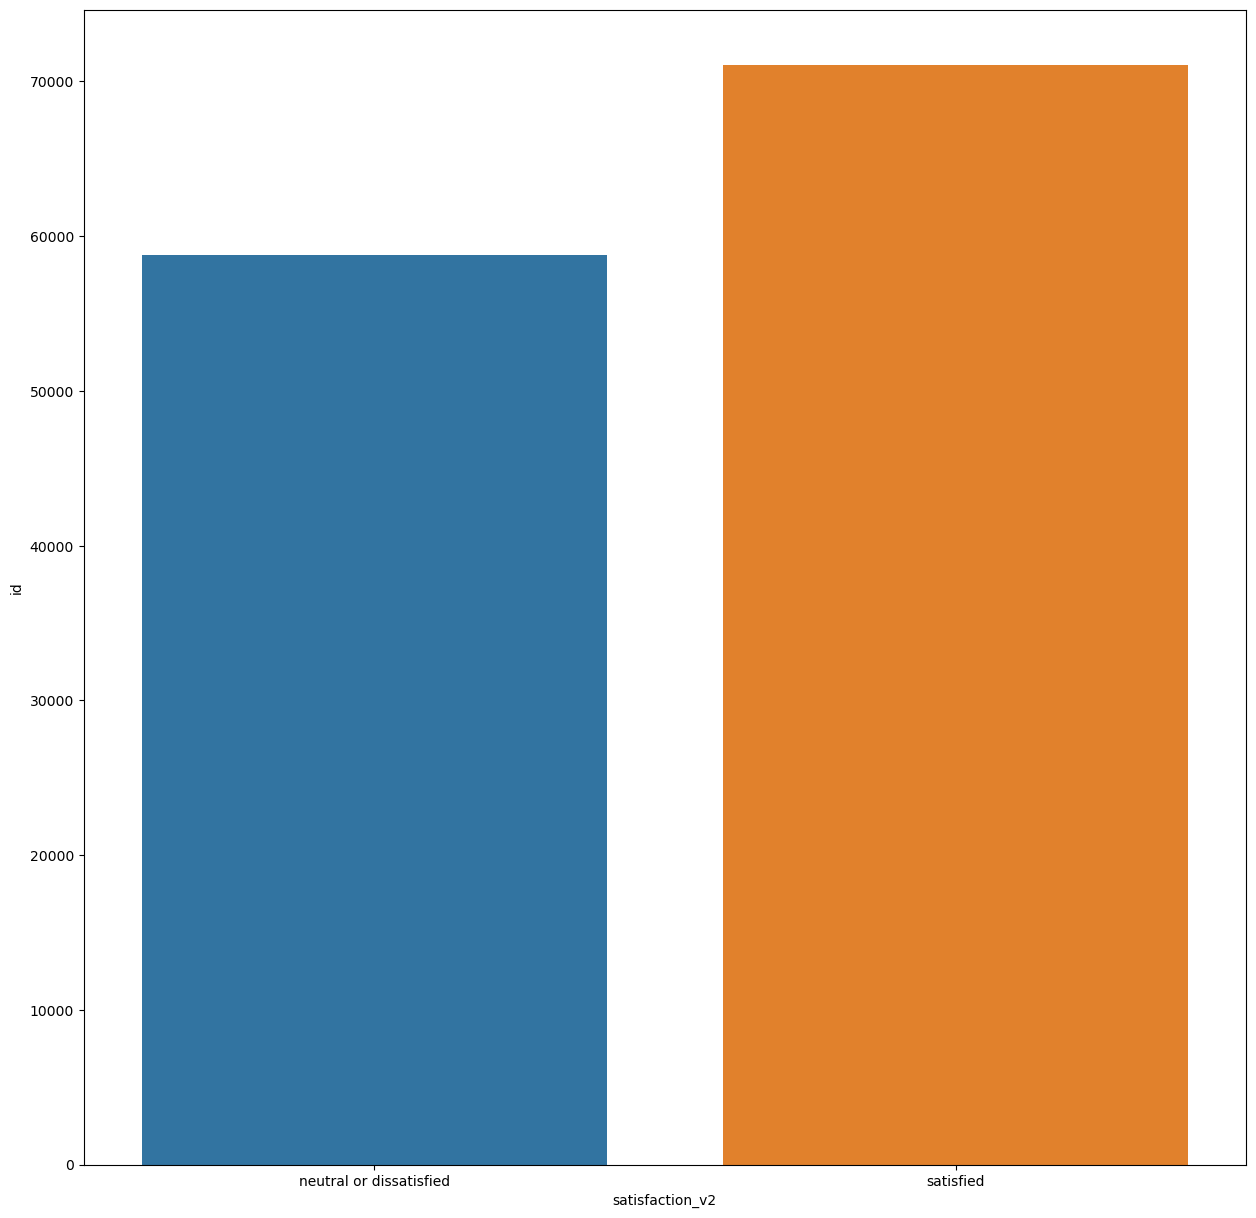

In [44]:
sat_cnt = pd.DataFrame(pdf.groupby('satisfaction_v2').count()['id'])

fig, axes = plt.subplots(figsize = (15, 15))
sns.barplot(data = sat_cnt, x = sat_cnt.index, y = 'id')

In [45]:
pax_sat_df_impute.groupBy('satisfaction_v2') \
    .count() \
    .toPandas()

,satisfaction_v2,count
0,neutral or dissatisfied,58793
1,satisfied,71087


In [46]:
stage_1 = ft.StringIndexer(inputCol = 'satisfaction_v2', outputCol = 'satisfaction_enc')
stage_2 = ft.StringIndexer(inputCol = 'Customer Type', outputCol = 'cust_type_enc')
stage_3 = ft.StringIndexer(inputCol = 'Class', outputCol = 'class_enc')
stage_4 = ft.StringIndexer(inputCol = 'Gender', outputCol = 'gender_enc')
stage_5 = ft.StringIndexer(inputCol = 'Type of Travel', outputCol = 'travel_type')

pipeline = ml.Pipeline(stages = [stage_1, stage_2, stage_3, stage_4, stage_5])

pipeline_model_train = pipeline.fit(pax_sat_df_impute)
hm_df = pipeline_model_train.transform(pax_sat_df_impute)
pdf = hm_df.toPandas()

In [47]:
pdf.columns

Index(['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age',
       'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction_enc', 'cust_type_enc', 'class_enc', 'gender_enc',
       'travel_type'],
      dtype='object')

In [48]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
cols = ['gender_enc', 'travel_type']
array_hot_encoded = ohe.fit_transform(pdf[cols])

In [49]:
ohe_df = pd.DataFrame.sparse.from_spmatrix(array_hot_encoded, columns = ['gender_fem', 'gender_male', 'business_travel', 'personal_travel'])
pdf = pd.concat([pdf, ohe_df], axis = 1)
pdf.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Arrival Delay in Minutes,satisfaction_enc,cust_type_enc,class_enc,gender_enc,travel_type,gender_fem,gender_male,business_travel,personal_travel
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,3,3,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,3,3,...,305.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,3,3,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,3,3,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,3,3,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


Resource: https://towardsdatascience.com/how-to-avoid-multicollinearity-in-categorical-data-46eb39d9cd0d 

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_70906/443046743.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pdf.corr(), vmin = 0, vmax = 1, annot = True, cmap = 'BrBG')


<AxesSubplot:>

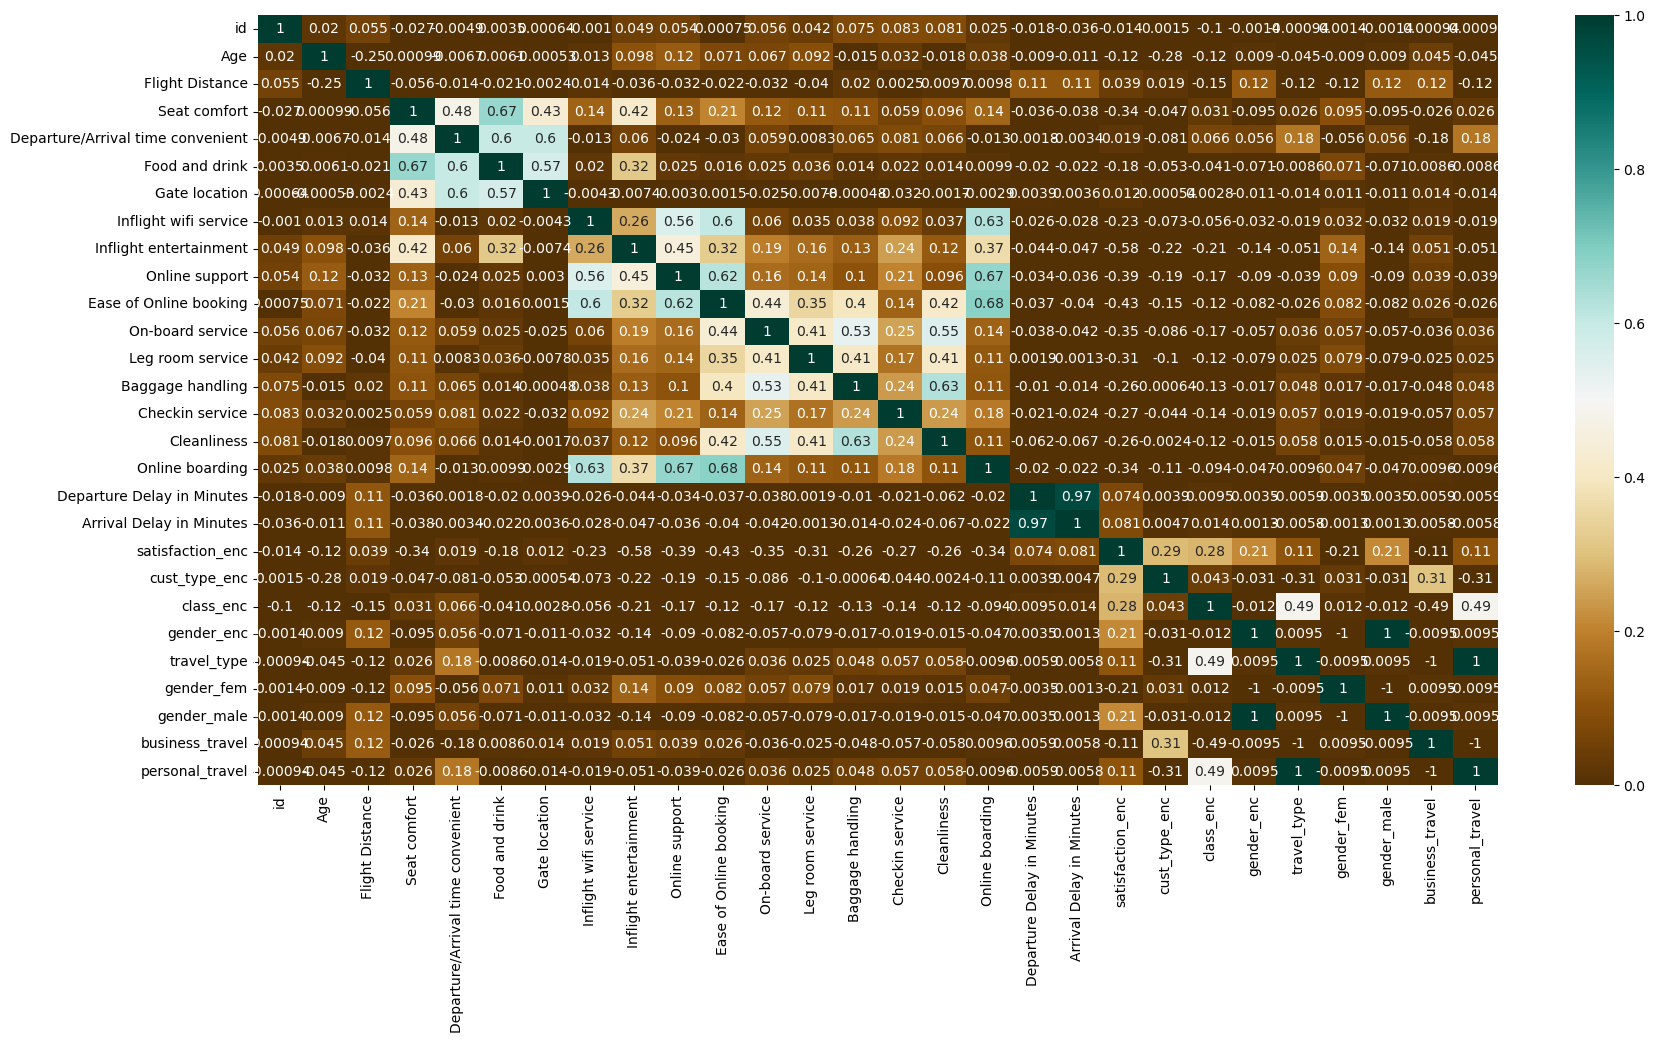

In [50]:
plt.figure(figsize = (20, 10))
sns.heatmap(pdf.corr(), vmin = 0, vmax = 1, annot = True, cmap = 'BrBG')

In [51]:
pax_sat_df = pax_sat_df_impute

## Conclusion

The correlation heat map for both the non-imputed and imputed dataset is similar, so let's opt to use the imputed data so that we can retain more data. 

In terms of potential feature engineering and transformations, we're using 0.7 as the minimum correlation coefficient to drop a column. However, only departure delay and arrival delay go beyond that threshold, and thus we'll drop one of them. I'm opting to not use any dimensionality reduction because of how large the dataset is compared to the number of features, and we want to analyze specifically which factors are affecting the passenger experience. 

After checking for class imbalance, there isn't a large difference in number of unique values so we don't need to do any resampling or weighting to handle class imbalance. 

After checking for outliers, there are many outliers for the flight distance and departure/arrival delay. However, these outliers should be consider as a legitimate observation that is a natural and normal aspect of the airline business. Thus, we will keep them in the dataset and try to analyze the results while taking into account of this. 

In [52]:
# imports for machine learning
import pyspark.ml as ml
from pyspark.ml import classification as cs
from pyspark.ml import feature as ft
from pyspark.ml import tuning as tg
from pyspark.ml import evaluation as eval

## Preprocessing Data

In [53]:
# making a copy of the dataset
pax_sat_df_ml = pax_sat_df

In [54]:
# splitting the data into training and testing sets
train, test = pax_sat_df_ml.randomSplit(weights = [0.8, 0.2], seed = 2002)

In [55]:
print(train.count())
train.select('*').limit(5).toPandas()

103987


,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,14,neutral or dissatisfied,Male,Loyal Customer,9,Personal Travel,Business,2614,1,5,...,5,5,4,3,4,5,5,5,68,76
1,17,satisfied,Female,Loyal Customer,48,Personal Travel,Eco,836,4,4,...,3,4,4,4,4,4,4,4,0,0
2,19,satisfied,Female,Loyal Customer,11,Personal Travel,Eco,2495,5,5,...,1,5,5,5,5,1,5,5,0,0
3,20,satisfied,Female,Loyal Customer,42,Personal Travel,Eco,870,5,1,...,2,5,5,5,5,3,5,3,4,0
4,21,satisfied,Female,Loyal Customer,14,Personal Travel,Eco,2292,1,1,...,4,4,4,5,4,4,4,5,12,1


In [56]:
print(test.count())
test.select('*').limit(5).toPandas()

25893


,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,15,neutral or dissatisfied,Male,Loyal Customer,52,Personal Travel,Eco,1706,2,4,...,2,2,3,3,5,3,5,2,0,0
1,16,neutral or dissatisfied,Male,Loyal Customer,70,Personal Travel,Eco,2538,2,5,...,5,5,4,2,4,4,5,5,0,0
2,18,satisfied,Female,Loyal Customer,61,Personal Travel,Eco,860,3,3,...,5,4,4,4,4,3,4,3,0,0
3,82,neutral or dissatisfied,Male,Loyal Customer,39,Personal Travel,Eco,1671,1,2,...,2,2,3,1,4,2,4,2,0,7
4,95,satisfied,Female,Loyal Customer,7,Personal Travel,Eco Plus,1699,4,4,...,1,4,4,4,4,3,4,4,18,35


Resource: 
- https://stackoverflow.com/questions/67753426/pyspark-combining-output-of-two-vectorassemblers 
- https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b
- https://www.analyticsvidhya.com/blog/2022/04/learn-about-apache-spark-using-python/

In [57]:
num_cols = ['Age', 'Departure Delay in Minutes', 'Flight Distance']
num_assembler = ft.VectorAssembler(
    inputCols = num_cols,
    outputCol = 'num_features'
)
standard_scaling = ft.StandardScaler(inputCol = 'num_features', outputCol = 'num_features_scaled')
cat_cols = ['satisfaction_v2', 'Customer Type', 'Class', 'Gender', 'Type of Travel']
indexers = [
    ft.StringIndexer(inputCol = c, outputCol = f'{c}_ind') for c in cat_cols
]
encoders = [
    ft.OneHotEncoder(
        inputCol = indexer.getOutputCol(),
        outputCol = f'{indexer.getOutputCol()}_enc'
    ) for indexer in indexers[3:]
]
cat_assembler = ft.VectorAssembler(
    inputCols = [indexer.getOutputCol() for indexer in indexers[:3]] + [encoder.getOutputCol() for encoder in encoders],
    outputCol = 'cat_features'
)

scaling_pipeline = ml.Pipeline(stages = [num_assembler, standard_scaling])
encoding_pipeline = ml.Pipeline(stages = indexers + encoders + [cat_assembler])

In [58]:
scaling_pipeline_model = scaling_pipeline.fit(train)
train_df = scaling_pipeline_model.transform(train)
encoding_pipeline_model = encoding_pipeline.fit(train_df)
train_df = encoding_pipeline_model.transform(train_df)

In [59]:
train_df.select('num_features_scaled', 'cat_features').limit(5).toPandas()

,num_features_scaled,cat_features
0,"[0.595413195755149, 1.790862967943008, 2.55077...","(1.0, 0.0, 0.0, 0.0, 0.0)"
1,"[3.175537044027461, 0.0, 0.815779664836737]","(0.0, 0.0, 1.0, 1.0, 0.0)"
2,"[0.7277272392562931, 0.0, 2.4346534255594006]","(0.0, 0.0, 1.0, 1.0, 0.0)"
3,"[2.7785949135240284, 0.10534488046723577, 0.84...","(0.0, 0.0, 1.0, 1.0, 0.0)"
4,"[0.9261983045080094, 0.3160346414017073, 2.236...","(0.0, 0.0, 1.0, 1.0, 0.0)"


In [60]:
other_features = pax_sat_df_ml.columns[8:23]
all_assemblers = ft.VectorAssembler(inputCols = ['num_features_scaled', 'cat_features'] + other_features, outputCol = 'all_features')
train_df = all_assemblers.transform(train_df)

In [61]:
print(train_df.columns)

['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'num_features', 'num_features_scaled', 'satisfaction_v2_ind', 'Customer Type_ind', 'Class_ind', 'Gender_ind', 'Type of Travel_ind', 'Gender_ind_enc', 'Type of Travel_ind_enc', 'cat_features', 'all_features']


In [62]:
train_df.select('all_features', 'satisfaction_v2_ind').limit(5).toPandas()

,all_features,satisfaction_v2_ind
0,"[0.595413195755149, 1.790862967943008, 2.55077...",1.0
1,"[3.175537044027461, 0.0, 0.815779664836737, 0....",0.0
2,"[0.7277272392562931, 0.0, 2.4346534255594006, ...",0.0
3,"[2.7785949135240284, 0.10534488046723577, 0.84...",0.0
4,"[0.9261983045080094, 0.3160346414017073, 2.236...",0.0


In [63]:
test_df = scaling_pipeline_model.transform(test)
encoding_pipeline_model = encoding_pipeline.fit(test_df)
test_df = encoding_pipeline_model.transform(test_df)

In [64]:
test_df.select('num_features_scaled', 'cat_features').limit(5).toPandas()

,num_features_scaled,cat_features
0,"[3.440165131029749, 0.0, 1.6647369715448246]","(1.0, 0.0, 1.0, 0.0, 0.0)"
1,"[4.630991522540047, 0.0, 2.4766133843966966]","(1.0, 0.0, 1.0, 0.0, 0.0)"
2,"[4.035578326784898, 0.0, 0.8391991767459256]","(0.0, 0.0, 1.0, 1.0, 0.0)"
3,"[2.580123848272312, 0.0, 1.6305835166772578]","(1.0, 0.0, 1.0, 0.0, 0.0)"
4,"[0.4630991522540047, 0.47405196210256095, 1.65...","(0.0, 0.0, 2.0, 1.0, 0.0)"


In [65]:
other_features = pax_sat_df_ml.columns[8:23]
all_assemblers = ft.VectorAssembler(inputCols = ['num_features_scaled', 'cat_features'] + other_features, outputCol = 'all_features')
test_df = all_assemblers.transform(test_df)
test_df.select('all_features', 'satisfaction_v2_ind').limit(5).toPandas()

,all_features,satisfaction_v2_ind
0,"[3.440165131029749, 0.0, 1.6647369715448246, 1...",1.0
1,"[4.630991522540047, 0.0, 2.4766133843966966, 1...",1.0
2,"[4.035578326784898, 0.0, 0.8391991767459256, 0...",0.0
3,"[2.580123848272312, 0.0, 1.6305835166772578, 1...",1.0
4,"[0.4630991522540047, 0.47405196210256095, 1.65...",0.0


## Model Training - Logistic Regression

Resource: 
- https://datascience.stackexchange.com/questions/78038/pyspark-crossvalidation-error 
- https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221

In [96]:
lr = cs.LogisticRegression(featuresCol = 'all_features', labelCol = 'satisfaction_v2_ind')
hp_grid = tg.ParamGridBuilder().addGrid(lr.maxIter, [1, 5]) \
    .addGrid(lr.regParam, [1.0, 2.0]) \
    .build()
evaluator = eval.BinaryClassificationEvaluator(metricName = 'areaUnderPR').setLabelCol('satisfaction_v2_ind')
cv = tg.CrossValidator(estimator = lr, estimatorParamMaps = hp_grid, evaluator = evaluator, parallelism = 4, seed = 2002)

In [97]:
cv_model = cv.fit(train_df)

22/11/27 19:33:16 WARN BlockManager: Block rdd_5033_0 already exists on this machine; not re-adding it
22/11/27 19:33:21 WARN BlockManager: Block rdd_5549_1 already exists on this machine; not re-adding it


Resource: https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark 

In [98]:
params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {cv_model.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cv_model.avgMetrics)
])

,areaUnderPR,maxIter,regParam
0,0.968341,1,1.0
1,0.968341,1,2.0
2,0.989509,5,1.0
3,0.982610,5,2.0


In [99]:
lr = cs.LogisticRegression(featuresCol = 'all_features', labelCol = 'satisfaction_v2_ind', maxIter = 5, regParam = 1.0)
lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)

In [101]:
print("Area Under Precision-Recall Curve: ", evaluator.evaluate(predictions))

Area Under Precision-Recall Curve:  0.9900700448597332


In [94]:
predictions.select('all_features', 'satisfaction_v2_ind', 'prediction', 'probability').toPandas().head()

,all_features,satisfaction_v2_ind,prediction,probability
0,"[3.440165131029749, 0.0, 1.6647369715448246, 1...",1.0,1.0,"[0.3107638035661316, 0.6892361964338685]"
1,"[4.630991522540047, 0.0, 2.4766133843966966, 1...",1.0,1.0,"[0.46938260483481054, 0.5306173951651895]"
2,"[4.035578326784898, 0.0, 0.8391991767459256, 0...",0.0,0.0,"[0.7123383612268054, 0.2876616387731946]"
3,"[2.580123848272312, 0.0, 1.6305835166772578, 1...",1.0,1.0,"[0.22012889501170765, 0.7798711049882924]"
4,"[0.4630991522540047, 0.47405196210256095, 1.65...",0.0,0.0,"[0.5162568515623981, 0.4837431484376019]"
